Raw shapes: (145, 145, 200) (145, 145)
Patches: (10249, 5, 5, 30) | classes: 16
Epoch 1/10
334/334 [==============================] - 4s 9ms/step - loss: 1.0728 - accuracy: 0.6404 - val_loss: 0.2813 - val_accuracy: 0.9019
Epoch 2/10
334/334 [==============================] - 3s 9ms/step - loss: 0.4003 - accuracy: 0.8641 - val_loss: 0.1666 - val_accuracy: 0.9419
Epoch 3/10
334/334 [==============================] - 4s 12ms/step - loss: 0.2913 - accuracy: 0.8996 - val_loss: 0.1297 - val_accuracy: 0.9571
Epoch 4/10
334/334 [==============================] - 5s 16ms/step - loss: 0.2312 - accuracy: 0.9243 - val_loss: 0.0940 - val_accuracy: 0.9625
Epoch 5/10
334/334 [==============================] - 7s 21ms/step - loss: 0.1942 - accuracy: 0.9361 - val_loss: 0.0702 - val_accuracy: 0.9735
Epoch 6/10
334/334 [==============================] - 4s 12ms/step - loss: 0.1703 - accuracy: 0.9421 - val_loss: 0.0640 - val_accuracy: 0.9752
Epoch 7/10
334/334 [==============================] - 4s 12ms/st

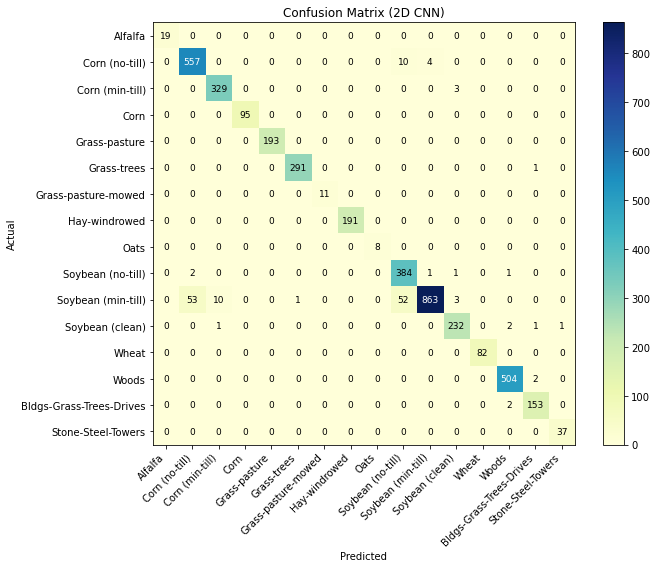


Generating full-scene prediction map (2D CNN)...


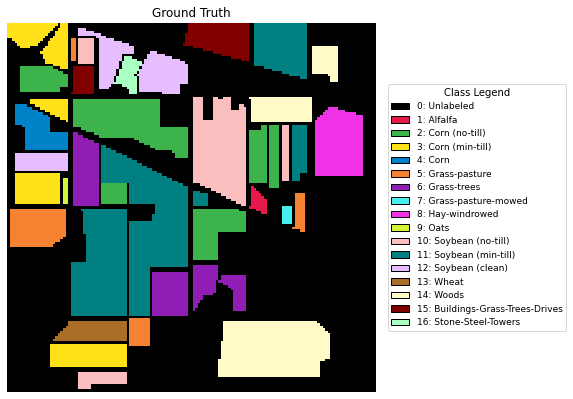

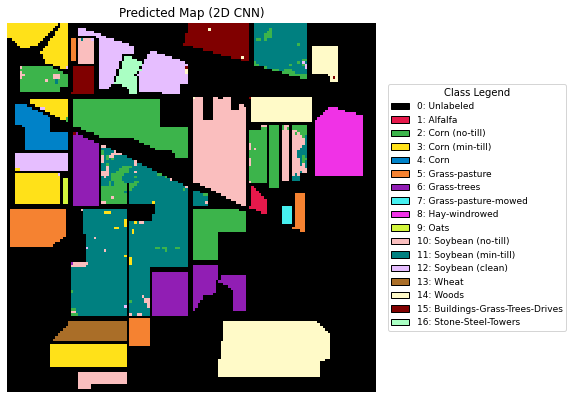

Saved: confusion_2d.png, ground_truth_2d.png, predicted_map_2d.png


In [1]:
# Indian Pines 2D CNN
import os
import time
import numpy as np
import scipy.io as sio
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, cohen_kappa_score
)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD

# ----------------------------
# Config
# ----------------------------
DATA_PATH = r"C:\Users\Pushkar Telavane\Desktop\HSI_IMAGE-20250529T110119Z-1-001\HSI_IMAGE\data"
numPCAComponents = 30
windowSize = 5               # MUST match for training and map prediction
testRatio = 0.40
batch_size = 64
epochs = 10
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

# Indian Pines class names d
IP_CLASSES = {
    0: "Unlabeled",
    1: "Alfalfa",
    2: "Corn (no-till)",
    3: "Corn (min-till)",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean (no-till)",
    11: "Soybean (min-till)",
    12: "Soybean (clean)",
    13: "Wheat",
    14: "Woods",
    15: "Buildings-Grass-Trees-Drives",
    16: "Stone-Steel-Towers",
}


CLASS_COLORS = [
    "#000000",  # 0 
    "#e6194b",  # 1
    "#3cb44b",  # 2
    "#ffe119",  # 3
    "#0082c8",  # 4
    "#f58231",  # 5
    "#911eb4",  # 6
    "#46f0f0",  # 7
    "#f032e6",  # 8
    "#d2f53c",  # 9
    "#fabebe",  # 10
    "#008080",  # 11
    "#e6beff",  # 12
    "#aa6e28",  # 13
    "#fffac8",  # 14
    "#800000",  # 15
    "#aaffc3",  # 16
]
IP_CMAP = ListedColormap(CLASS_COLORS)
IP_NORM = BoundaryNorm(np.arange(-0.5, 16.5 + 1, 1), IP_CMAP.N)

# ----------------------------
# Data loading
# ----------------------------
def loadIndianPinesData(data_path=DATA_PATH):
    X = sio.loadmat(os.path.join(data_path, "Indian_pines_corrected.mat"))["indian_pines_corrected"]
    y = sio.loadmat(os.path.join(data_path, "Indian_pines_gt.mat"))["indian_pines_gt"]
    return X, y

# ----------------------------
# Preprocessing
# ----------------------------
def standartizeData(X):
    flat = X.reshape(-1, X.shape[2])
    scaler = StandardScaler().fit(flat)
    flat = scaler.transform(flat)
    return flat.reshape(X.shape), scaler

def applyPCA(X, n_components):
    flat = X.reshape(-1, X.shape[2])
    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    flat = pca.fit_transform(flat)
    return flat.reshape(X.shape[0], X.shape[1], n_components), pca

def padWithZeros(X, margin=2):
    H, W, B = X.shape
    newX = np.zeros((H + 2*margin, W + 2*margin, B), dtype=X.dtype)
    newX[margin:margin+H, margin:margin+W, :] = X
    return newX

def createPatches(X, y, windowSize=5, removeZeroLabels=True):
    """
    Return:
      patchesData: (N, ws, ws, B)
      patchesLabels: (N,) zero-based if removeZeroLabels=True
    """
    margin = windowSize // 2
    Xpad = padWithZeros(X, margin)
    H, W, B = X.shape
    N = H * W

    patchesData = np.zeros((N, windowSize, windowSize, B), dtype=X.dtype)
    patchesLabels = np.zeros((N,), dtype=y.dtype)

    idx = 0
    for r in range(margin, margin + H):
        for c in range(margin, margin + W):
            patchesData[idx] = Xpad[r - margin:r + margin + 1, c - margin:c + margin + 1, :]
            patchesLabels[idx] = y[r - margin, c - margin]
            idx += 1

    if removeZeroLabels:
        mask = patchesLabels > 0
        patchesData = patchesData[mask]
        patchesLabels = patchesLabels[mask] - 1  
    return patchesData, patchesLabels

def oversampleWeakClasses(X, y, seed=42):
    unique, counts = np.unique(y, return_counts=True)
    maxc = counts.max()
    X_list, y_list = [], []
    for cls, cnt in zip(unique, counts):
        reps = int(np.round(maxc / cnt))
        Xc = X[y == cls]
        yc = np.full((Xc.shape[0],), cls, dtype=y.dtype)
        X_list.append(np.repeat(Xc, reps, axis=0))
        y_list.append(np.repeat(yc, reps, axis=0))
    Xn = np.concatenate(X_list, axis=0)
    yn = np.concatenate(y_list, axis=0)
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(yn))
    return Xn[perm], yn[perm]

def AugmentData(X_train, seed=123):
    """
    Augment first half of the training set with random flip or rotation.
    Returns a new array.
    """
    rng = np.random.default_rng(seed)
    X_aug = X_train.copy()
    n = X_aug.shape[0] // 2
    for i in range(n):
        patch = X_aug[i]
        op = rng.integers(0, 3)  # 0: flipud, 1: fliplr, 2: rotate
        if op == 0:
            patch2 = np.flipud(patch)
        elif op == 1:
            patch2 = np.fliplr(patch)
        else:
            angle = int(rng.choice(np.arange(-180, 181, 30)))
            patch2 = ndi.rotate(
                patch, angle=angle, axes=(0, 1),
                reshape=False, order=3, mode="constant", cval=0.0, prefilter=False
            )
        X_aug[i] = patch2
    return X_aug

def splitTrainTestSet(X, y, testRatio=0.25, seed=345):
    return train_test_split(X, y, test_size=testRatio, random_state=seed, stratify=y)

# ----------------------------
# 2D Model
# ----------------------------
def build_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ----------------------------
# Metrics helpers (OA, AA, Kappa, inference time)
# ----------------------------
def compute_metrics(model, X_test, y_test, n_classes, batch_size=64):
    """
    y_test must be integer class ids (0..C-1).
    Returns dict with OA, AA, Kappa, Test Loss, Test Acc, Inference Time, CM.
    """
    # ensure one-hot for Keras evaluate
    y_test_cat = to_categorical(y_test, num_classes=n_classes)

    # test loss/acc from Keras
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size, verbose=0)

    # inference time on X_test
    t0 = time.time()
    y_pred_probs = model.predict(X_test, batch_size=batch_size, verbose=0)
    inf_time = time.time() - t0

    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test

    # OA
    oa = accuracy_score(y_true, y_pred) * 100.0
    # Kappa
    kappa = cohen_kappa_score(y_true, y_pred) * 100.0
    # AA from confusion matrix (mean per-class recall)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class_recall = np.diag(cm) / cm.sum(axis=1)
    aa = np.nanmean(per_class_recall) * 100.0

    return {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa,
        "Test_Loss": float(test_loss),
        "Test_Acc": test_acc * 100.0,
        "Inference_Time_s": inf_time,
        "Confusion_Matrix": cm,
        "y_pred": y_pred
    }

# ----------------------------
# Window Predciation
# ----------------------------
def predict_map(model, X_pca, y_gt, windowSize):
    H, W = y_gt.shape
    outputs = np.zeros((H, W), dtype=np.int32)
    half = windowSize // 2
    Xpad = padWithZeros(X_pca, half)
    for i in range(0, H):
        for j in range(0, W):
            if y_gt[i, j] == 0:
                continue
            r0, c0 = i, j
            patch = Xpad[r0:r0+windowSize, c0:c0+windowSize, :]
            X_in = patch[np.newaxis, ...].astype('float32') 
            pred = np.argmax(model.predict(X_in, verbose=0), axis=1)[0]  
            outputs[i, j] = pred + 1
    return outputs

# ----------------------------
# Plotting 
# ----------------------------
def show_class_map(arr2d, title, cmap=IP_CMAP, norm=IP_NORM, save_path=None, classes_present=None):
    """
    Display a labeled map with a legend mapping class IDs to names.
    classes_present: optional iterable of class ids present in the image
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(arr2d.astype(int), cmap=cmap, norm=norm, interpolation='nearest')
    plt.title(title)
    plt.axis('off')

 
    if classes_present is None:
        classes_present = np.unique(arr2d.ravel().astype(int))
    handles = []
    for cid in classes_present:
        if cid < 0 or cid > 16:
            continue
        label = f"{cid}: {IP_CLASSES.get(cid, 'Unknown')}"
        handles.append(Patch(facecolor=CLASS_COLORS[cid], edgecolor='k', label=label))
   
    if handles:
        plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
                   frameon=True, title="Class Legend", fontsize=9, title_fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

def plot_confusion(cm, class_names, title="Confusion Matrix (2D CNN)", save_path=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='YlGnBu')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:d}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=9)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

# ----------------------------
# Main Function
# ----------------------------
if __name__ == "__main__":
    # Load
    X, y = loadIndianPinesData()
    print("Raw shapes:", X.shape, y.shape)  

    # Standardize -> PCA
    X_std, _ = standartizeData(X)
    X_pca, pca = applyPCA(X_std, numPCAComponents) 

    # Patches 
    XPatches, yPatches = createPatches(X_pca, y, windowSize=windowSize, removeZeroLabels=True)
    n_classes = int(yPatches.max() + 1)
    print("Patches:", XPatches.shape, "| classes:", n_classes)

    # Splitting
    X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

    X_train, y_train = oversampleWeakClasses(X_train, y_train, seed=seed)
    X_train = AugmentData(X_train, seed=seed)

    y_train_cat = to_categorical(y_train, num_classes=n_classes)
    y_test_cat  = to_categorical(y_test,  num_classes=n_classes)

    # Building & training
    input_shape = X_train.shape[1:]   # (ws, ws, bands)
    model = build_cnn(input_shape, n_classes)
    history = model.fit(
        X_train, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # Evaluating with metrics 
    metrics = compute_metrics(model, X_test, y_test, n_classes, batch_size=batch_size)
    print("\n=== 2D CNN Evaluation (extended) ===")
    print(f"OA: {metrics['OA']:.2f}% | AA: {metrics['AA']:.2f}% | Kappa: {metrics['Kappa']:.2f}%")
    print(f"Test Loss: {metrics['Test_Loss']:.4f} | Test Acc: {metrics['Test_Acc']:.2f}% | Inference time: {metrics['Inference_Time_s']:.2f}s")

    # classification report
    print("\nClassification report (2D CNN):")
    try:
        target_names = [
            'Alfalfa','Corn (no-till)','Corn (min-till)','Corn',
            'Grass-pasture','Grass-trees','Grass-pasture-mowed','Hay-windrowed',
            'Oats','Soybean (no-till)','Soybean (min-till)','Soybean (clean)',
            'Wheat','Woods','Bldgs-Grass-Trees-Drives','Stone-Steel-Towers'
        ]
        print(classification_report(y_test, metrics["y_pred"], target_names=target_names, digits=4))
    except Exception:
        print(classification_report(y_test, metrics["y_pred"], digits=4))

    # Confusion matrix plot
    cm = metrics["Confusion_Matrix"]
    class_names = target_names if len(target_names) == cm.shape[0] else [str(i) for i in range(cm.shape[0])]
    plot_confusion(cm, class_names, title="Confusion Matrix (2D CNN)", save_path="confusion_2d.png")

    # Predict full map =
    print("\nGenerating full-scene prediction map (2D CNN)...")
    outputs = predict_map(model, X_pca, y, windowSize)

    
    gt_present = np.unique(y)
    pred_present = np.unique(outputs)
    show_class_map(y, "Ground Truth", save_path="ground_truth_2d.png", classes_present=gt_present)
    show_class_map(outputs, "Predicted Map (2D CNN)", save_path="predicted_map_2d.png", classes_present=pred_present)

    print("Saved: confusion_2d.png, ground_truth_2d.png, predicted_map_2d.png")
